In [1]:
from grale.all_nb import *
import pandas as pd
import pickle
import matplotlib.pyplot as plt

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [2]:
zd = 0.039
zs = 1.695

cosm = cosmology.Cosmology(0.7, 0.3, 0, 0.7)
cosmology.setDefaultCosmology(cosm)
Dd = cosm.getAngularDiameterDistance(zd)
Ds = cosm.getAngularDiameterDistance(zs)
Dds = cosm.getAngularDiameterDistance(zd, zs)

# Load the result from the grale based parametric inversion, from the MCMC step
inv = lenses.GravitationalLens.load("mcmcInv.lensdata")

In [3]:
# Prepare LensInfo object, to plot the results
li = plotutil.LensInfo(inv, size=4*ANGLE_ARCSEC, zd=zd, zs=zs)

In [4]:
# Load the input images, and add them to an InversionWorkSpace (will be
# used to backproject the images)
imgList = images.readInputImagesFile("./images.txt", True)

iws = inversion.InversionWorkSpace(zd, 10*ANGLE_ARCSEC)
for i in imgList:
    iws.addImageDataToList(i["imgdata"], i["z"], "pointimages")

Text(value='')

FloatProgress(value=0.0)

Text(value='')

FloatProgress(value=0.0)

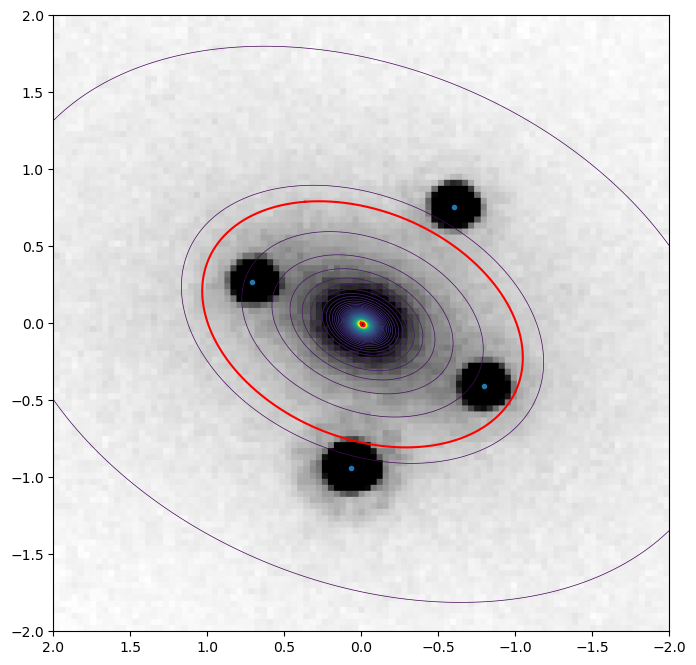

In [5]:
# Mass map of the solution, as well as the backprojected images
plt.figure(figsize=(8,8))
plt.imshow(plt.imread("4x4gray_inv.jpg"), extent=[2,-2,-2,2])
plotutil.plotDensityContours(li, levels=np.arange(0,500,5), linewidths=[0.5])
plotutil.plotImagePlane(li, plotCaustics=False, bgRgb=(0,0,0,0))
plotutil.plotImagesData(imgList)
plt.gca().invert_xaxis()


In [6]:
def velDispToB(sigma):
    return (Dds/Ds)*4*np.pi*(sigma/SPEED_C)**2

def fToEccentricity(f):
    axRatio = f**2
    return (1-axRatio)/(1+axRatio)

# A helper function to print the properties of the solutions
def printLens(l):
    compParams = l.getLensParameters()
    assert len(compParams) == 1
    nsie = compParams[0]["lens"]
    nsieParams = nsie.getLensParameters()
    x, y, angle = compParams[0]["x"]/ANGLE_ARCSEC, compParams[0]["y"]/ANGLE_ARCSEC, compParams[0]["angle"]
    velDisp = nsieParams["velocityDispersion"]/1000
    b = velDispToB(nsieParams["velocityDispersion"])/ANGLE_ARCSEC
    f = nsieParams["ellipticity"]
    e = fToEccentricity(f)
    core = nsieParams["coreRadius"]/ANGLE_ARCSEC
    print(f"""x:                {x:.5g} arcsec
y:                {y:.5g} arcsec
angle:            {angle:.5g} deg
180-angle:        {180-angle:.5g} deg
veldisp:          {velDisp:.5g} km/s
b (Einst rad):    {b:.5g} arcsec
corerad:          {core:.5g} arcsec
ellipticity (f):  {f:.5g}
eccentricity (e): {e:.5g}
""")

In [7]:
# Show the properties of the best solution from the GRALE parametric inversion,
# as well as the RMS
printLens(inv)
rms = util.calculateRMS(util.calculateImagePredictions(imgList, inv, cosmology=cosm), ANGLE_ARCSEC)["full"]
print(f"\nRMS: {rms:.3g} arcsec")

x:                -0.0067467 arcsec
y:                -0.0068124 arcsec
angle:            112.68 deg
180-angle:        67.324 deg
veldisp:          179.34 km/s
b (Einst rad):    0.89495 arcsec
corerad:          0.0001 arcsec
ellipticity (f):  0.68002
eccentricity (e): 0.36759


RMS: 0.00842 arcsec


In [8]:
# Up till now we were just looking at the best solution that was encountered during the
# MCMC routine. But the samples from the MCMC chains were written out as well, so we can
# generate some statistical information

# Read the information about the parameters that were being optimized. This was written
# in the inversion script, and it contains a name for each parameter in the samples file
# as well as a scale factor. This scale factor is needed to convert the values from the
# samples file to regular units, as they use some arbitratry units to keep the calculated
# values in a sensible range
paramInfo = pickle.load(open("./paraminfo.dat", "rb"))
names = [ x["name"] for x in paramInfo ]
scales = np.array([ x["scalefactor"] for x in paramInfo ]).reshape((1,-1))
list(zip(names,scales[0,]))

[('x_0_scaled', np.float64(8.337237871209333e-06)),
 ('y_0_scaled', np.float64(8.337237871209333e-06)),
 ('angle_0', np.float64(57.29577951308232)),
 ('lens_0,ellipticity', np.float64(1.0)),
 ('lens_0,sigma_scaled', np.float64(100000.0))]

In [9]:
# Read the samples file, reshape it so that it has some amount of rows, each containing the
# values for the parameters in the sample. The amount of values per sample is ultimately
# obtained fro the "paraminfo.dat" file
samples = np.fromfile("samples.dat", dtype=np.float32).reshape((-1,len(names))).astype(np.float64)
# Rescale the values to get the correct units
scaledSamples = samples*scales

In [10]:
# Here we'll first build a pandas dataframe from these values. We'll also rename and rescale some other columns

df = pd.DataFrame(scaledSamples, columns=names).copy()
# Use velocitydispersion and ellipticity instead of centraldensity and epsilon
df["velocitydispersion_km_s"] = df["lens_0,sigma_scaled"]/1000
df["b_arcsec"] = velDispToB(df["lens_0,sigma_scaled"])/ANGLE_ARCSEC
df["ellipticity"] = df["lens_0,ellipticity"]
df["eccentricity"] = fToEccentricity(df["lens_0,ellipticity"])
del df["lens_0,ellipticity"]
del df["lens_0,sigma_scaled"]

# Scale to arcsec for convenience
df["x_arcsec"] = df["x_0_scaled"]/ANGLE_ARCSEC
df["y_arcsec"] = df["y_0_scaled"]/ANGLE_ARCSEC

del df["x_0_scaled"]
del df["y_0_scaled"]

df["angle_degree"] = df["angle_0"]
del df["angle_0"]

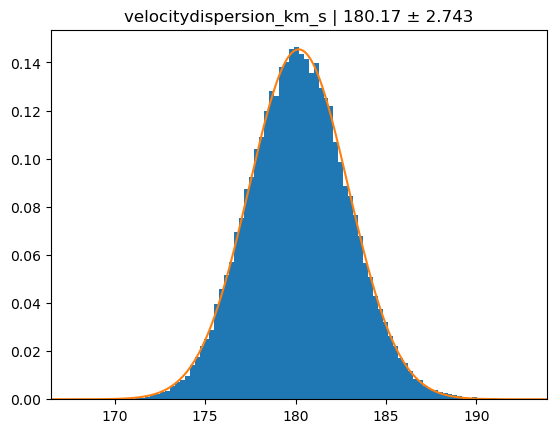

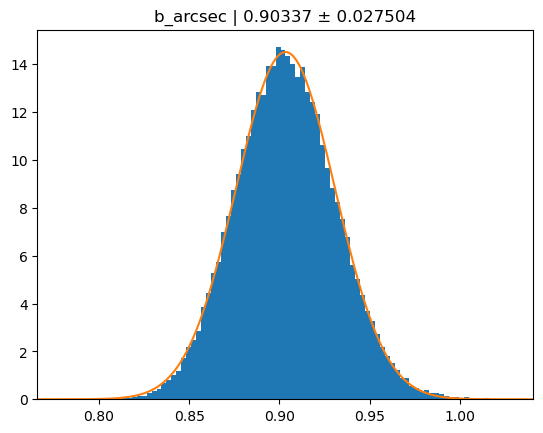

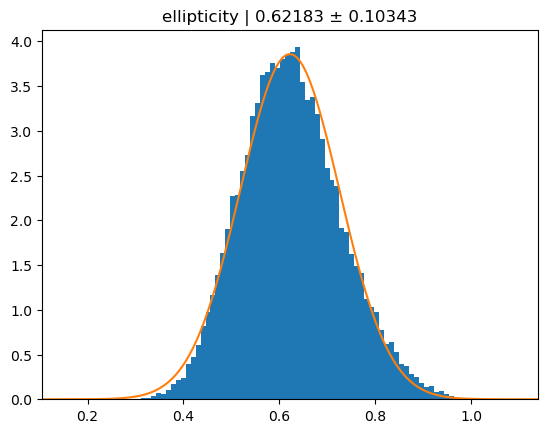

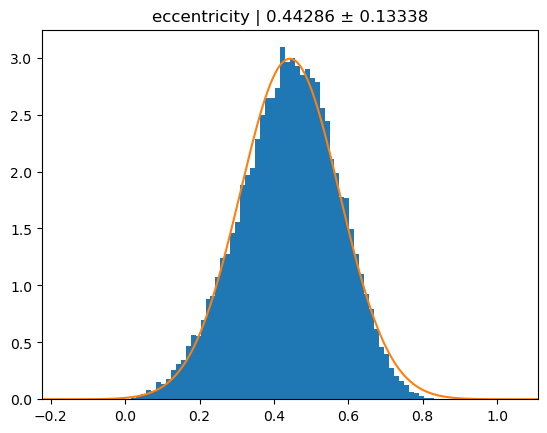

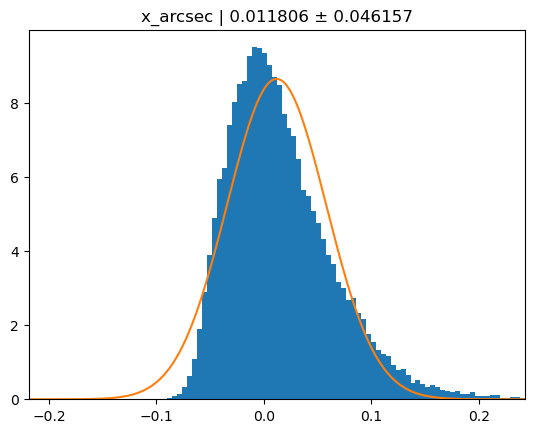

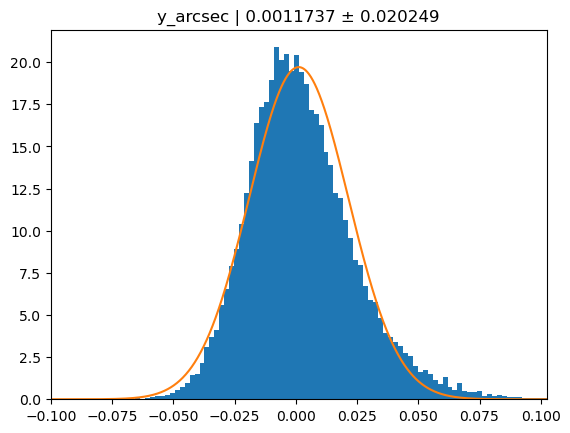

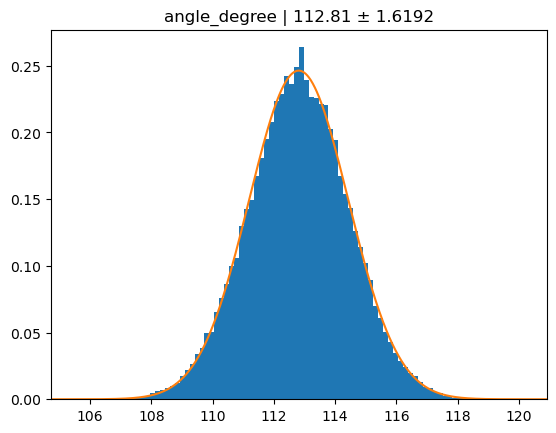

In [11]:
# For each column in the dataframe above, plot such a histogram
for n in df.columns:
    plt.figure()
    plotutil.plotHistogram1D(df[n], title=n, showMuSigma=True, plotGaussianApprox=True, plotBars=True)